<a href="https://colab.research.google.com/github/fastdatascience/clinical_trial_risk/blob/fixes_nov_2022/train/ctgov/TrainPhaseClassifier_06_Random_Forest_Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_annotations = pd.read_csv("/content/drive/MyDrive/data/all_annotations.csv")


In [4]:
with open("/content/drive/MyDrive/data/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [5]:
from nltk.tokenize import RegexpTokenizer

# Words and fractions and percentages
tok = RegexpTokenizer(r'\d+[\.,]\d+%?|[\w%]+|=|≤|≥|<|>')


def tokenise_text(page: str) -> list:
    """
    Tokenise the content of a single page
    :param page:
    """
    for word in tok.tokenize(page):
        yield word

def tokenise_text_and_lowercase(page: str) -> list:
    """
    Tokenise the content of a single page and return the lowercase of each token
    :param page:
    """
    for word in tok.tokenize(page):
        yield word.lower()

def tokenise_pages(pages):
    """
    Tokenises the lists of pages and returns a list of lists.
    This is a custom tokeniser as nunbers and percentages should not be split (e.g. 5.5%).

    :param pages: List of strings which each correspond to the content of a single page.
    :return: List of lists of tokens.
    """
    tokenised_pages = []

    for page in pages:
        tokens = []
        for word in tokenise_text(page):
            tokens.append(word)
        tokenised_pages.append(tokens)
    return tokenised_pages



def iterate_tokens(tokenised_pages):
    for page_no, tokens in enumerate(tokenised_pages):
        for token_no, token in enumerate(tokens):
            yield page_no, token_no, token

In [19]:
import spacy
from spacy.matcher import PhraseMatcher

import spacy

#nlp = spacy.load('en_core_web_sm', disable=['ner', 'tagger', 'parser', 'lemmatizer'])
nlp = spacy.blank("en")


phase_synonyms = {0: ['phase 0', 'pilot study'],
                  0.5: ['early phase i', 'early phase 1', 'early phase 1.0', 'phase 0.5'],
                  1: ['phase i', 'phase 1 b', 'phase 1', 'phase 1.0'],
                  1.5: ['phase i ii', 'phase 1 2', 'phase 1 2 a'],
                  2: ['phase ii', 'phase 2 b', 'phase 2', 'phase 2.0'],
                  2.5: ['phase 2.5', 'phase ii iii'],
                  3: ['phase iii', 'phase 3', 'phase 3.0'],
                  4: ['phase iv', 'phase 4', 'phase 4.0', 'phase 4 a', 'phase 4 b'],
                  }

phrase_matcher = PhraseMatcher(nlp.vocab)

for phase_number, synonyms in phase_synonyms.items():
    phases = [nlp.make_doc(text) for text in synonyms]

    phrase_matcher.add(f"Phase {phase_number}", None, *phases)


class PhaseExtractor:

    def process(self, tokenised_pages: list) -> tuple:
        """
        Identify the trial phase.
        :param tokenised_pages: List of lists of tokens of each page.
        :return: The prediction (str) and a map from phase to the pages it's mentioned in.
        """

        tokenised_pages = [[string.lower() for string in sublist] for sublist in tokenised_pages]

        phase_to_pages = {}

        for page_number, page_tokens in enumerate(tokenised_pages):
            doc = spacy.tokens.doc.Doc(
                nlp.vocab, words=page_tokens)
            phrase_matches = phrase_matcher(doc)
            for word, start, end in phrase_matches:
                phase_number = nlp.vocab.strings[word]
                if phase_number not in phase_to_pages:
                    phase_to_pages[phase_number] = []
                phase_to_pages[phase_number].append(page_number)

        phase_to_pages = sorted(phase_to_pages.items(), key=lambda v: len(v[1]), reverse=True)

        prediction = 0
        if len(phase_to_pages) > 0:
            prediction = float(phase_to_pages[0][0].split(" ")[1])

        return {"prediction": prediction, "pages": dict(phase_to_pages)}

        # return {"prediction": prediction, "pages": []}


In [20]:
df_train = df_annotations[df_annotations.train_val == "train"]

In [28]:
phase_map = {'Early Phase 1':0.5,
 'Not Applicable':0,
 'Phase 1':1,
 'Phase 1/Phase 2':1.5,
 'Phase 2':2,
 'Phase 2/Phase 3':2.5,
 'Phase 3':3,
 'Phase 4':4}

In [163]:
df_annotations_small = df_annotations.sample(10000)

In [166]:
X_train = []
y_train = [] 
X_val = []
y_val = []

for idx in range(len(df_annotations_small)):
  file_name = df_annotations_small.file.iloc[idx]
  if pd.isna(file_name):
    continue
    
  pages= file_to_pages[file_name]

  tokenised_pages = tokenise_pages(pages)
  gt = df_annotations_small.phase.iloc[idx]

  if pd.isna(gt):
    continue

  gt_float = float(phase_map[gt])
  
  
  tokenised_pages = [[string.lower() for string in sublist] for sublist in tokenised_pages]

  phase_to_pages = {}

  for page_number, page_tokens in enumerate(tokenised_pages):
      doc = spacy.tokens.doc.Doc(
          nlp.vocab, words=page_tokens)
      phrase_matches = phrase_matcher(doc)
      for word, start, end in phrase_matches:
          phase_number = nlp.vocab.strings[word]
          if phase_number not in phase_to_pages:
              phase_to_pages[phase_number] = []
          phase_to_pages[phase_number].append(page_number)

  phase_to_pages = sorted(phase_to_pages.items(), key=lambda v: len(v[1]), reverse=True)

  for idx, (phase, pages) in enumerate(phase_to_pages):
    phase_float = float(re.sub(r'\D', '', phase))
    feat_vect = [phase_float, len(pages), min(pages), max(pages), idx]
    y = int(phase_float == gt_float)

    if df_annotations_small.train_val.iloc[idx] == "train":
      X_train.append(feat_vect)
      y_train.append(y)
    else:
      X_val.append(feat_vect)
      y_val.append(y)

  # if len(X_train) > 10000:
  #   break

In [167]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_val = np.asarray(X_train)
y_val = np.asarray(y_train)

In [168]:
from sklearn.linear_model import LogisticRegression

In [169]:
m = LogisticRegression()

In [170]:
m.fit(X_train, y_train)

LogisticRegression()

In [171]:
m.coef_

array([[-0.10728961, -0.02841911, -0.05716272,  0.0023544 , -0.6897593 ]])

In [172]:
y_train

array([0, 1, 0, ..., 0, 0, 0])

In [173]:
y_pred = m.predict(X_val)

In [174]:
import bz2
with bz2.open("phase_logistic", "wb") as f:
    pkl.dump(m, f)

In [175]:
from sklearn.metrics import accuracy_score

In [176]:
accuracy_score(y_val, y_pred)

0.885067444979096

In [177]:
y_pred_proba = m.predict_proba(X_val)

In [178]:
from sklearn.ensemble import RandomForestClassifier

In [179]:
m = RandomForestClassifier()

In [180]:
m.fit(X_train, y_train)

RandomForestClassifier()

In [181]:
y_pred = m.predict(X_val)

In [182]:
accuracy_score(y_val, y_pred)

0.9795692987299834

In [183]:
y_pred_proba = m.predict_proba(X_val)

In [218]:
import bz2
with bz2.open("phase_rf_classifier", "wb") as f:
    pkl.dump(m, f)

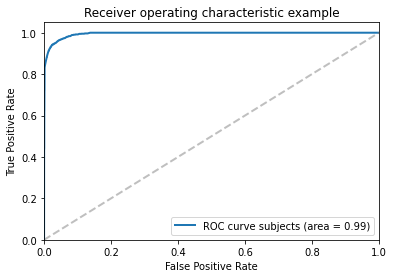

In [185]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
    
fpr, tpr, _ = roc_curve(y_val, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(
    fpr,
    tpr,
    # color="darkorange",
    lw=lw,
    label=f"ROC curve subjects (area = {roc_auc:0.2f})"
)
plt.plot([0, 1], [0, 1], color="gray", alpha=0.5, lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

# Test the Phase Extractor

In [202]:
from os.path import exists

import spacy
from spacy.matcher import PhraseMatcher
import numpy as np
import bz2
import pickle as pkl
phase_synonyms = {0: ['phase 0', 'pilot study'],
                  0.5: ['early phase i', 'early phase 1', 'early phase 1.0', 'phase 0.5'],
                  1: ['phase i', 'phase 1 b', 'phase 1', 'phase 1.0'],
                  1.5: ['phase i ii', 'phase 1 2', 'phase 1 2 a'],
                  2: ['phase ii', 'phase 2 b', 'phase 2', 'phase 2.0'],
                  2.5: ['phase 2.5', 'phase ii iii'],
                  3: ['phase iii', 'phase 3', 'phase 3.0'],
                  4: ['phase iv', 'phase 4', 'phase 4.0', 'phase 4 a', 'phase 4 b'],
                  }

phrase_matcher = PhraseMatcher(nlp.vocab)

for phase_number, synonyms in phase_synonyms.items():
    phases = [nlp.make_doc(text) for text in synonyms]

    phrase_matcher.add(f"Phase {phase_number}", None, *phases)


class PhaseExtractor:


    def __init__(self, path_to_classifier):
        print("Initialising Phase Random Forest classifier", path_to_classifier)
        if not exists(path_to_classifier):
            print(
                f"WARNING! UNABLE TO LOAD PHASE RANDOM FOREST CLASSIFIER {path_to_classifier}. You need to run the training script.")
            self.model = None
            return
        with bz2.open(path_to_classifier, "rb") as f:
            self.model = pkl.load(f)

    def process(self, tokenised_pages: list) -> tuple:
        """
        Identify the trial phase.
        :param tokenised_pages: List of lists of tokens of each page.
        :return: The prediction (str) and a map from phase to the pages it's mentioned in.
        """

        tokenised_pages = [[string.lower() for string in sublist] for sublist in tokenised_pages]

        phase_to_pages = {}

        for page_number, page_tokens in enumerate(tokenised_pages):
            doc = spacy.tokens.doc.Doc(
                nlp.vocab, words=page_tokens)
            phrase_matches = phrase_matcher(doc)
            for word, start, end in phrase_matches:
                phase_number = nlp.vocab.strings[word]
                if phase_number not in phase_to_pages:
                    phase_to_pages[phase_number] = []
                phase_to_pages[phase_number].append(page_number)

        phase_to_pages = sorted(phase_to_pages.items(), key=lambda v: len(v[1]), reverse=True)

        X = []
        for idx, (phase, pages) in enumerate(phase_to_pages):
            phase_float = float(re.sub(r'\D', '', phase))
            feat_vect = np.asarray([phase_float, len(pages), min(pages), max(pages), idx])

            X.append(feat_vect)

        X = np.asarray(X)

        if len(X) > 0:

          probas = self.model.predict_proba(X)[:,1]

          scores = {}
          for (phase, pages), score in zip(phase_to_pages, probas):
              scores[phase] = score

          prediction = max(scores, key=scores.get)
        else:
          prediction = "Phase 0"
          scores = {}

        prediction = 0
        if len(phase_to_pages) > 0:
            prediction = float(phase_to_pages[0][0].split(" ")[1])


        return {"prediction": prediction, "pages": dict(phase_to_pages), "scores":scores}


In [203]:
pe = PhaseExtractor("phase_rf_classifier")

Initialising Phase Random Forest classifier phase_rf_classifier


In [204]:
df_val = df_annotations[(df_annotations.train_val == "val") & (~df_annotations.file.isna())& (~df_annotations.phase.isna())].sample(100)

In [205]:
y_pred  = []
for idx in range(len(df_val)):
  file_name = df_annotations_small.file.iloc[idx]
    
  pages= file_to_pages[file_name]

  tokenised_pages = tokenise_pages(pages)

  result = pe.process(tokenised_pages)

  y_pred.append(result["prediction"])

In [206]:
gts = df_val.phase.map(phase_map).apply(float).apply(str)

In [213]:
preds= [str(float(re.sub(r'\D.*', '', str(x)))) for x in y_pred]

In [214]:
set(df_val.phase), set(y_pred)

({'Early Phase 1',
  'Not Applicable',
  'Phase 1',
  'Phase 1/Phase 2',
  'Phase 2',
  'Phase 2/Phase 3',
  'Phase 3',
  'Phase 4'},
 {0.0, 1.0, 2.0, 3.0, 4.0})

In [215]:
accuracy_score(gts, preds)

0.22

In [216]:
df_val["ground_truth"] = gts
df_val["pred"] = preds

In [217]:
df_val

,file,nct_id,train_val,num_arms,num_subjects,phase,intervention_type,country,has_sap,text,ground_truth,pred
2503,20_NCT03886220_Prot_000.pdf,NCT03886220,val,2.0,82.0,Phase 4,Drug,"US,PR,HU,PL",0,\nNCT03886220\n\n \nSTUDY M16-824 | Version ...,4.0,0.0
9585,80_NCT02849080_Prot_000.pdf,NCT02849080,val,2.0,504.0,Phase 3,Drug,"US,AR,AT,BE,BR,EG,KR,NO,CH,TR",0,\nCover Page for Protocol \n \n\nSponsor name:...,3.0,3.0
9584,80_NCT02841280_Prot_SAP_000.pdf,NCT02841280,val,2.0,160.0,Phase 2,Drug,US,1,\n1 | F i n a l P r o t o c o l\n\nNCT number...,2.0,2.0
3494,29_NCT02853929_Prot_000.pdf,NCT02853929,val,2.0,551.0,Phase 4,Biological,"AU,CA,CZ,FI,IT,ES,CZ",0,\nCONFIDENTIAL\n\n12-DEC-2016 1\n\nClinical St...,4.0,0.0
5598,47_NCT01880047_Prot_SAP_000.pdf,NCT01880047,val,2.0,35.0,Phase 2,Drug,US,1,\n IRB #1207012741 \n\n NCT01880047 \n\nDocu...,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10290,86_NCT02806986_Prot_000.pdf,NCT02806986,val,1.0,61.0,Phase 3,Biological,"AU,CZ,FR,DE,HU,PL,ES,SE,GB,CZ",0,"\n \n\nOfficial Title: A Multi-Center, Open-La...",3.0,2.0
1614,13_NCT02848313_Prot_SAP_000.pdf,NCT02848313,val,2.0,40.0,Phase 1,Drug,US,1,\nElamipretide (MTP-131) SPIAM-101 Clinical Pr...,1.0,1.0
9539,80_NCT01832480_Prot_SAP_000.pdf,NCT01832480,val,2.0,623.0,Phase 3,Drug,US,1,\n \n\nVersion: 11.0 \nVersion date: 1/2/17 \n...,3.0,2.0
10845,91_NCT01823991_Prot_SAP_000.pdf,NCT01823991,val,2.0,36.0,Early Phase 1,Drug,US,1,\n \n\n \n\nPilot Trial of COGNUTRIN in Breast...,0.5,0.0
